In [6]:
import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import seaborn as sns

sns.set_theme(style='darkgrid')

class HyperOptPlotter:
    
    def __init__(self, path):
        self.path = path 
        self.df = self.load_file()
        
    def load_file(self):
        return pd.read_json(self.path)

    def sort_scores(self): 
        """Return the best cross-validation score from the hyperparam tuning. """
        vals = self.df['loss']
        sign = np.min(vals) < 0
    
        ascending = True if sign else False
    
        df_sorted = self.df.sort_values(by='loss', ascending=ascending)
        df_sorted.reset_index(inplace=True, drop=True)
        
        return df_sorted
    
    def _determine_best_hyparams(self,):
        """Using correlation coef. determine the top 2 hyperparameters for explaining the loss 
        variance"""
        self.df.drop(['iteration', 'loss_variance', 'train_time', 'rank_test_score'], 
                     axis=1, inplace=True,
                    errors='ignore')
        correlation = self.df.corr(numeric_only=True)['loss']

        corr_rank = correlation.abs().sort_values(ascending=False) 
        print('....Correlation of Hyperparams with Loss...')
        print(corr_rank)
        
        # Exclude the first one as it is loss itself
        return list(corr_rank[1:3].index)
    
    def plot(self, params=None):

        if params is None:
            params = self._determine_best_hyparams()
        
        fig, ax = plt.subplots(dpi=100, figsize=(5,4))
    
        loss = self.df['loss']
        
        cmap = plt.cm.Reds
        #bounds = np.linspace(np.percentile(loss, 10), np.percentile(loss, 90.), 5)
        #norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        norm = colors.Normalize(vmin=np.percentile(loss, 10), vmax=np.percentile(loss, 90))
        
        sca = ax.scatter(self.df[params[0]], self.df[params[1]], s=30, c=loss, 
                        cmap = cmap, norm=norm)
        
        # Check if log scale is needed for each parameter
        for param in params:
            if self.df[param].min() > 0 and self.df[param].max() / self.df[param].min() > 1000:
                ax.set_xscale('log') if param == params[0] else ax.set_yscale('log')

        xlabel = params[0]
        ylabel = params[1]
        
        xlabel = xlabel.replace('param_model__', '')
        ylabel = ylabel.replace('param_model__', '')
        
        ax.set(xlabel= xlabel, 
               ylabel = ylabel,
              title='Hyperparameter Tuning Results\n 2 best hyperparameters')
        
        fig.colorbar(sca, label='Loss', extend='both')
        
        return fig, ax

In [7]:
path = 'hyperopt_results.json'
# Sort dataframe and print the results. 
plotter = HyperOptPlotter(path)
plotter.sort_scores()

,train_time,loss,loss_variance,rank_test_score,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth
0,3.188582,0.526824,0.090092,1,100,15,5,10,10
1,5.077709,0.521499,0.088773,2,400,4,15,8,10
2,3.013487,0.520580,0.090351,3,100,4,4,8,10
3,4.577442,0.486890,0.092046,4,500,25,10,6,8
4,3.736150,0.454568,0.093281,5,400,25,5,5,6


....Correlation of Hyperparams with Loss...
loss                              1.000000
param_model__max_depth            0.996672
param_model__max_features         0.922911
param_model__min_samples_split    0.804314
param_model__n_estimators         0.626863
param_model__min_samples_leaf     0.173405
Name: loss, dtype: float64


(<Figure size 500x400 with 2 Axes>,
 <Axes: title={'center': 'Hyperparameter Tuning Results\n 2 best hyperparameters'}, xlabel='max_depth', ylabel='max_features'>)

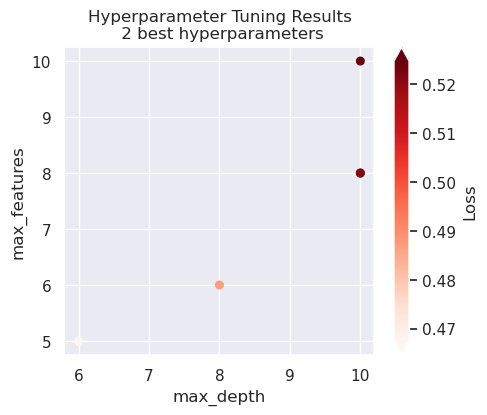

In [8]:
plotter.plot()